# 前言

Ang et al.2006公开发表论文 The Cross-Section of Volatility and Expected Returns，提出股票的特质波动率与未来收益之间存在显著的负相关性，且该现象不能被 规模、价值、动量和流动性等市场已知因子所解释。这篇论文的实证结果，颠覆了传统
金融学中“风险越大，收益越高”的经典理论，被称为“低波动率异常现象”。

*其实学术界一直区分异象(anomaly)和因子(factor)，但工业界是有超额收益为王没有严格区分*

*Ang A , Hodrick R J , Xing Y , et al. The Cross-Section of Volatility and Expected Returns[J]. 2006, 61(1):259-299*

In [1]:
import numpy as np
import pandas as pd
import alphalens as al
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn import linear_model

from dateutil.parser import parse
from tqdm import tqdm_notebook # 进度条

from jqdata import *
from jqfactor import (Factor,calc_factors,neutralize,get_factor_values)

# 画图
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.style.use('seaborn')

# 函数准备

In [2]:
def get_stockpool(watch_date:str)->list:
    
    '''获取股票池'''
    
    stockList = get_index_stocks('000002.XSHG', date=watch_date) + get_index_stocks(
                '399107.XSHE', date=watch_date)
    
    stockList = del_st_stock(stockList,watch_date)
    stockList = del_iponday(stockList,watch_date)
    stockList = del_paused(stockList,watch_date)
    
    return stockList

def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()


def del_iponday(securities: list, watch_date: str, N: int=60) -> list:
    '''返回上市大于N日的股票'''
    return list(filter(lambda x: (parse(watch_date).date() - get_security_info(x, date=watch_date).start_date).days > N, securities))


def del_paused(securities: list, watch_date: str, N: int=21) -> list:
    '''返回N日内未停牌的股票'''
    pausd_df = get_price(securities, end_date=watch_date,
                         count=N, fields='paused', panel=False)
    cond = pausd_df.groupby('code')['paused'].sum()

    return cond[cond == 0].dropna().index.tolist()


def plot_nav(nav: pd.DataFrame, title: str):
    
    '''画图'''
    
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(18, 6))
    # 设置标题
    plt.title(title)
    # 1,5组设置不同的颜色和线型方便查看单调性
    ax.plot(nav[1.], color='Navy')
    ax.plot(nav[2.], color='LightGrey', ls='-.')
    ax.plot(nav[3.], color='DimGray', ls='-.')
    ax.plot(nav[4.], color='DarkKhaki', ls='-.')
    ax.plot(nav[5.], color='LightSteelBlue')
    
    ax.axhline(1, color='black', lw=0.5)
    # 多空单独反应
    ax1 = ax.twinx()
    ax1.plot(nav['G1-G5'], color='r', ls='--')
    ax1.grid(None)
    # 图例合并
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax1.get_legend_handles_labels()
    l2 = [l2[0] + '(right)']
    ax.legend(h1+h2, l1+l2)

# 传统特质波动率因子

## 特质波动率因子的计算与回测
本文选取一种目前广泛使用的构造方法，计算传统的特质波动率因子。具体地，以全体A股为研究样本（剔除其中的ST股、停牌股以及上市不足 60 个交易日的次新股），以 2014/01/01-2020/10/30为回测时间段，实施以下操作:

**第一步**，每月月底，回溯所有股票过去 20 个交易日的数据，每只股票都根据FamaFrench三因子模型(下文简称FF3模型)进行回归，得到每日的特质收益率，即:
$$r_{i,t} = \alpha_{i,t}+\beta_{i,t}MKT_t+\eta_{i,t}SMB_t+\lambda_{i,t}HML_t+\epsilon_t$$

>其中，𝑡取值为 1,2,3,……,20；$𝑀𝐾𝑇_𝑡$为𝑡日全市场收益率；$𝑆𝑀𝐵_𝑡$为市值因子， 取𝑡日流通市值最小的1/3部分股票按照流通市值加权构建小市值股票组合，取流通市值 最大的 1/3 部分股票按照流通市值加权构建大市值股票组合，当日小市值组合收益率与 大市值组合收益率之差，即为市值因子；$𝐻𝑀𝐿_𝑡$为估值因子，取𝑡日市净率PB 最低的 1/3 部分股票按照流通市值加权构建低估值股票组合，取市净率 PB 最大的 1/3 部分股票按 照流通市值加权构建高估值股票组合，当日低估值组合收益率与高估值组合收益率之差，即为估值因子；上述回归得到的残差𝜀𝑖,𝑡，即为第𝑖个股票𝑡日的特质收益率；

上述表达为FF3模型最经典的构造方式(学术界版本)，本文中使用的FF3的构造方式与[【量化课堂】Fama-French三因子火锅](https://www.joinquant.com/view/community/detail/46084e11dc11457b9390fac67ae9a173?type=1)相同是FF3的一种极简构造方式：
- a 市值采用最新交易日的总市值，BM为最近报告期净资产除以最新交易日总市值
- b 按照总市值从小到大将所有股票分为10组，每组股票数量相同且市值加权，做多第1组且做空第10组得到SMB
- c 按照BM从小到大将所有股票分为 10 组，每组股票数量相同且市值加权，做多第10 组且做空第1组得到 HML


**第二步**，计算每只股票20个特质收益率的标准差，即为股票剔除FF3因子后的特质波动率，记为ID_Vol(Idiosyncratic Volatility)。

In [107]:
class ID_Vol(Factor):

    name = 'ID_Vol'
    max_window = 21
    dependencies = ['market_cap', 'pb_ratio', 'close']

    def calc(self, data):
        
        # 获取bm
        bm_df = 1. / data['pb_ratio']
        # 收益率
        returns = data['close'].pct_change()
        # 分组标记
        market_cap_label = self.add_label(data['market_cap'], 10)
        bm_label = self.add_label(bm_df, 10)
        # 构造因子
        smb = self.calc_longshort(data, market_cap_label, returns, 1, 10)
        hml = self.calc_longshort(data, bm_label, returns, 10, 1)
        mkt = (data['market_cap'].div(data['market_cap'].sum(
            axis=1), axis=0) * returns).sum(axis=1)

        # 添加阶矩项项
        exog = sm.add_constant(pd.concat([mkt, smb, hml], axis=1))
        EXOG_COL = ['constant', 'mkt', 'smb', 'hml']
        exog.columns = EXOG_COL

        returns = returns.iloc[-20:]
        exog = exog.reindex(returns.index)  # 日期索引对齐
        # OLS回归获取残差
        mod = sm.OLS(returns, exog)
        res = mod.fit()
        resid_df = res.resid

        return resid_df.iloc[-20:].std()

    def calc_longshort(self, data, label_df: pd.DataFrame, returns: pd.DataFrame, high: int, low: int) -> pd.Series:
        '''计算多空收益 high - low'''

        # 计算组合权重
        l_w = self.get_weight(label_df, data['market_cap'], high)
        s_w = self.get_weight(label_df, data['market_cap'], low)

        h = (l_w * returns).sum(axis=1)
        l = (s_w * returns).sum(axis=1)

        return h - l

    @staticmethod
    def add_label(df: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取分组 分位数分组(每组数量相同)'''
        return df.apply(lambda x: pd.qcut(x, N, labels=[i for i in range(1, N+1)]), axis=1)

    @staticmethod
    def get_weight(label_df: pd.DataFrame, market_cap: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取目标组的权重'''

        cond = (label_df == N)
        cap = cond * market_cap  # 该组市值

        return cap.div(cap.sum(axis=1), axis=0)
    
def get_factor(start_date:str,end_date:str,factor):
    
    # 屏蔽Factor类提取行情数据的警告
    import warnings
    warnings.filterwarnings("ignore")
        
    periods = GetTradePeriod(start_date,end_date)
    
    factor_list = []
    for i in tqdm_notebook(periods,desc='数据获取中'):
        
        stocks = get_stockpool(i.strftime('%Y-%m-%d'))
        
        factor_list.append(calc_factors(stocks,
                                    factors=[factor],
                                    start_date=i,
                                    end_date=i)[factor.name])
        
    factor_df = pd.concat(factor_list,sort=False)
    
    return factor_df

def get_factor_price(factor:pd.DataFrame,last_date:str)->pd.DataFrame:
    
    periods = [i.strftime('%Y-%m-%d') for i in factor.index.tolist()] + [last_date]
    stocks = factor.columns.tolist()
    df_list = []
    for i in tqdm_notebook(periods,desc='收益率下载中'):
        
        df_list.append(get_price(stocks,end_date=i,count=1,fields='close',panel=False))
        
    df = pd.concat(df_list)
    close = pd.pivot_table(df,index='time',columns='code',values='close')
    return close

# 获取年末季末时点

def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()

In [28]:
# 获取特质因子
id_vol = get_factor('2013-01-01','2020-09-30',ID_Vol())

In [5]:
# 获取价格数据
pricing = get_factor_price(id_vol,'2020-10-31')

In [6]:
# 数据储存
id_vol.to_csv('../Data/id_vol.csv')
pricing.to_csv('../Data/priceing.csv')

In [4]:
# 数据读取
id_vol = pd.read_csv('../Data/id_vol.csv',index_col=[0],parse_dates=[0])
pricing = pd.read_csv('../Data/priceing.csv',index_col=[0],parse_dates=[0])

# 以2014年为起点
id_vol_1 = id_vol.loc['2014-01-01':]
pricing_1 = pricing.loc['2014-01-01':]

In [5]:
# 因子分组排序默认未从小到大
id_vol_factor = al.utils.get_clean_factor_and_forward_returns(id_vol_1.stack(),
                                                            pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)
# 计算分组收益
rets = pd.pivot_table(id_vol_factor.reset_index(level=0),
                      index='date', columns='factor_quantile', values=1)

rets['G1-G5'] = rets[1] - rets[5] 
nav = (1 + rets).cumprod() # 计算净值

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


通过分组净值曲线可以看到分组的单调性很好

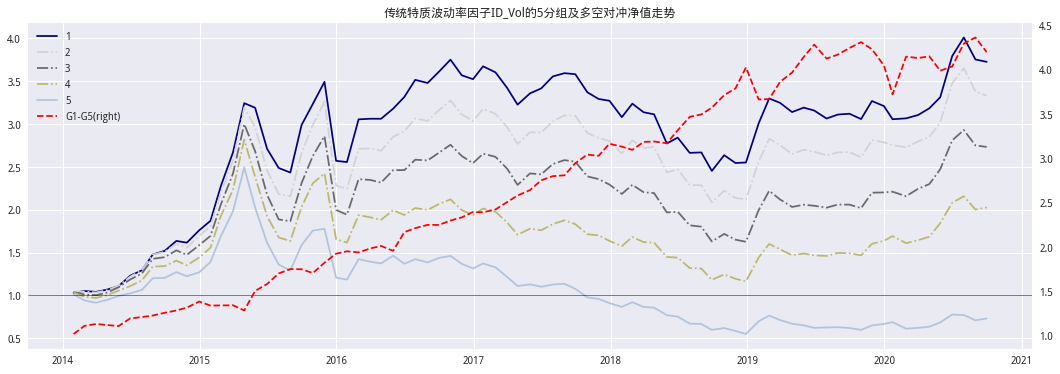

In [6]:
plot_nav(nav,'传统特质波动率因子ID_Vol的5分组及多空对冲净值走势')

In [7]:
id_vol_ic = al.performance.factor_information_coefficient(id_vol_factor)
id_vol_ic.columns=['ID_Vol']
al.plotting.plot_information_table(id_vol_ic)

Information Analysis


,ID_Vol
IC Mean,-0.112
IC Std.,0.129
Risk-Adjusted IC,-0.864
t-stat(IC),-7.775
p-value(IC),0.000
IC Skew,0.060
IC Kurtosis,1.017


## 特质波动率因子与换手率因子的相关性

多项实证研究表明，波动率与换手率包含的价量信息重叠度较高，因此两个因子往往高度相关。此处，我们每月月底取每只股票过去20个交易日换手率的平均值，再做**市值中性化**处理，定义为换手率因子Turn20。特质波动率因子ID_Vol与换手率因子Turn20的平均月度相关系数较高。若更进一步，每月月底将特质波动率因子ID_Vol 对换手率因子Turn20 做横截面正交化处理，即：
$$ID\_Vol\_i=\alpha+bTrun20_i+\epsilon_i$$

将残差视为波动率剔除换手率线性信息之后的选股因子，记为ID_Vol_deTurn20。同样以全体A股为研究样本，以2014/01/01-2020/09/30 为回测时间段，ID_Vol_deTurn20 因子的月度 IC 均值为-0.030，年化 ICIR为-1.05，5 分组多空对冲的年化收益为 6.08%， 信息比率降至 0.61，月度胜率 59.78%，最大回撤 17.70%。下图 2 展示了 ID_Vol_deTurn20 因子 5 分组及多空对冲的净值走势，表 2 则汇总对比了 ID_Vol、Turn20、ID_Vol_deTurn20因子的月度 IC 均值、年化 ICIR及多空对冲的各项绩效指标。

In [8]:
def get_idvol_deturn20(factor: pd.DataFrame) -> pd.DataFrame:
    '''
    计算idvol_deturn20因子
    -------------
        本质是因子与换手率因子正交，如果传入的是ID_Vol因子则生成idvol_deturn20
    '''
    stocks = factor.columns.tolist()
    periods = [i.strftime('%Y-%m-%d') for i in factor.index]

    vol_list = []
    for i in tqdm_notebook(periods, desc='数据获取中'):

        tmp_dic = get_factor_values(
            stocks, factors=['VOL20'], end_date=i, count=1)
        vol_list.append(neutralize(tmp_dic['VOL20'], how='market_cap', date=i))

    turn20 = pd.concat(vol_list)
    turn20 = turn20.fillna(0)
    
    # 正交化

    def get_resid(x): return sm.OLS(factor.loc[:, x].fillna(
        0), sm.add_constant(turn20.loc[:, x])).fit().resid
    
    idvol_deturn20 = pd.concat((get_resid(code) for code in stocks), axis=1)
    idvol_deturn20.columns = stocks
    
    return idvol_deturn20, turn20  # 返回idvol_deturn20和turn20因子

In [9]:
# 获取ID_Vol_deTurn20和换手率因子
idvol_deturn20,turn20 = get_idvol_deturn20(id_vol_1)

In [10]:
# 转换格式
idvol_deturn20_ = idvol_deturn20.stack().dropna()
turn20_ = turn20.stack().dropna()

# 因子分组排序默认未从小到大
idvol_deturn20_factor = al.utils.get_clean_factor_and_forward_returns(idvol_deturn20_,
                                                            pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)

turn20_factor = al.utils.get_clean_factor_and_forward_returns(turn20_,
                                                            pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)

# 计算分组收益
rets1 = pd.pivot_table(idvol_deturn20_factor.reset_index(level=0),
                      index='date', columns='factor_quantile', values=1)

rets1['G1-G5'] = rets1[1] - rets1[5] 
nav1 = (1 + rets1).cumprod() # 计算净值

Dropped 17.0% entries from factor data (17.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 17.0% entries from factor data (17.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


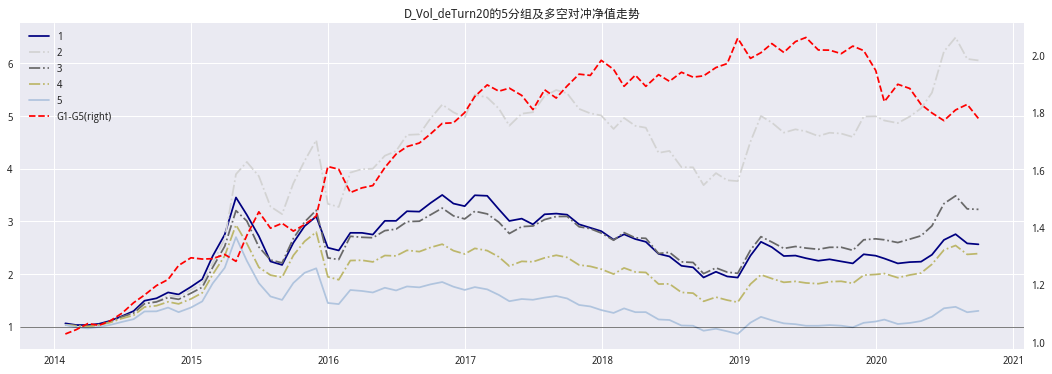

In [11]:
plot_nav(nav1,'D_Vol_deTurn20的5分组及多空对冲净值走势')

## 特质波动率因子小结

根据下表，对传统特质波动率因子作如下总结：
1. 整体来看，传统特质波动率因子ID_Vol具备不错的选股效果；
2. 特质波动率因子ID_Vol与换手率因子Turn20的信息重叠度较高，但ID_Vol的选股效果不如Turn20;
3. 特质波动率因子正交化换手率因子后，残差 ID_Vol_deTurn20的选股效果大幅下降。

因此，即使传统的特质波动率因子已经具有不错的选股能力，但也仍然存在改进空 间。下文我们将逐步深入探索，寻找改进波动率因子的有效方案。

In [12]:
idvol_deturn20_ic = al.performance.factor_information_coefficient(idvol_deturn20_factor)
turn_ic = al.performance.factor_information_coefficient(turn20_factor)

id_vol_ic['ID_Vol_deTurn20'] = idvol_deturn20_ic
id_vol_ic['turn20'] = turn_ic
al.plotting.plot_information_table(id_vol_ic)

Information Analysis


,ID_Vol,ID_Vol_deTurn20,turn20
IC Mean,-0.112,-0.031,-0.079
IC Std.,0.129,0.072,0.201
Risk-Adjusted IC,-0.864,-0.431,-0.394
t-stat(IC),-7.775,-3.881,-3.549
p-value(IC),0.000,0.000,0.001
IC Skew,0.060,0.201,0.459
IC Kurtosis,1.017,0.376,-0.127


# 波动聚集：波动率因子的时序和截面相关性

Cont通过实证研究发现，金融资产收益的时间序列数据，通常表现出波动率聚集 现象（Volatility Clustering），即价格的大幅变化往往倾向于聚集在一起。该现象也明显 存在于A股市场中，如下图展示了上证综指日收益率的变化情况，我们可以发现，指数的大幅波动确实具有聚集性。

*Cont:Cont R . Volatility Clustering in Financial Markets: Empirical Facts and Agent-Based Models.[J]. Ssrn Electronic Journal, 2005*

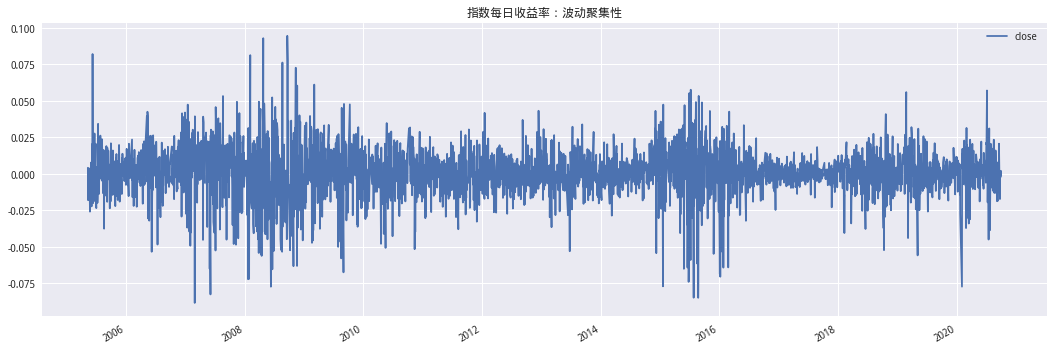

In [13]:
index_price = get_price('000001.XSHG', start_date='2005-05-01',
                        end_date='2020-09-30', fields='close')

index_price.pct_change().plot(figsize=(18, 6), title='指数每日收益率：波动聚集性')

更进一步，**若波动率聚集现象也存在于个股层面，则会导致个股的波动率因子具有 较强的时序和截面相关性。**我们在全体A股样本内，计算了传统特质波动率因子ID_Vol的平均时序相关系数，在滞后阶数较小时，波动率因子的时序相关系数都较大，如滞后阶数为1时，月频特质波动率因子的平均时序相关系数为0.43，说明个股层面确实存在波动率聚集现象。随着滞后阶数的增加，时序、截面相关系数都逐渐减小，滞后阶数为8时，平均时序相关系数下降至0.065，已小于0.034。

In [14]:
acf_df = id_vol.apply(lambda x:acf(x,nlags=12))
corr_df = pd.concat((id_vol.corrwith(id_vol.shift(-i)) for i in range(0,13)),axis=1)

df = pd.concat((corr_df.T.mean(axis=1),acf_df.mean(axis=1)),axis=1)
df.columns = ['平均截面相关系数','平均时序相关系数']

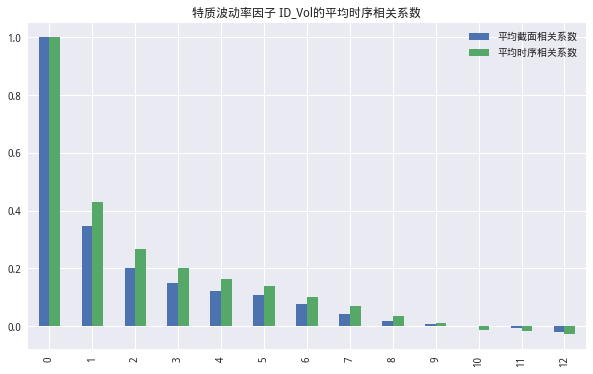

In [15]:
plt.rcParams['font.family'] = 'serif'
df.plot.bar(title='特质波动率因子 ID_Vol的平均时序相关系数',figsize=(10,6))

# 剔除跨期截面相关性：纯波动率因子

## 纯真波动率因子的构建与回测

特质波动率因子具有较强的时序和截面相关性。对于选股模型，若因子具有较强的跨期截面相关性，则会导致我们在t时刻选股时，虽然表面上只参考 了 t-1 时刻的因子值，却不可避免地连带使用了 t-2 时刻、t-3 时刻、甚至 t-4 时刻的因子 信息，而这些早期的因子值，无疑被多次重复使用了。这就意味着我们每一期获得的因子信息，其实都不够纯净。

基于上述分析，我们提出一种“剔除跨期截面相关性，寻找纯真选股信息”的方案， 具体实施以下操作：

获取ID_Vol因子后滞后阶数N=6,即每月月底将本月因子值对过去6个月的因子值做多元线性回归，即
$$ID\_Vol_{i,t}=\alpha_i+\theta_1ID\_Vol_{i,t-1}+\theta_2ID\_Vol_{i,t-2}+\dots+\theta_6ID\_Vol_{i,t-6}+\mu_{i,t}$$
其中i为个股,t为时间,取残差向量$\mu_{i,t}$，即为该月所有股票剔除截面相关性之后的波动率因子值，记为纯波动率因子`ID_Vol_deCorr`

In [49]:
def get_id_vol_deCorr(factor:pd.DataFrame,N:int)->pd.DataFrame:
    '''获取id_vol_deCorr因子'''
    N = N + 1
    
    def get_resid(factor:pd.DataFrame)->pd.Series:
        
        x = factor.iloc[:6].T.fillna(0)
        y = factor.iloc[-1].dropna()
        
        x = x.reindex(y.index)
        #regr = linear_model.Ridge()
        #regr.fit(x, y)
        #resid = y - regr.predict(x)
        resid = sm.OLS(y,sm.add_constant(x)).fit().resid
        resid.name = factor.index[-1]
        
        return resid
    
    iidx = np.arange(len(factor))
    
    shape = (iidx.size - N + 1, N)
    
    strides = (iidx.strides[0], iidx.strides[0])
    
    res = np.lib.stride_tricks.as_strided(
        iidx, shape=shape, strides=strides, writeable=True)
    
    return pd.concat((get_resid(factor.iloc[i]) for i in res),axis=1,sort=True).T

In [50]:
# 计算因子
id_vol_deCorr = get_id_vol_deCorr(id_vol,6)

In [52]:
# 因子分组排序默认未从小到大
id_vol_deCorr_ = id_vol_deCorr.loc['2014-01-01':].stack().dropna()
id_vol_deCorr_factor = al.utils.get_clean_factor_and_forward_returns(id_vol_deCorr_,
                                                            pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)
# 计算分组收益
rets2 = pd.pivot_table(id_vol_deCorr_factor.reset_index(level=0),
                      index='date', columns='factor_quantile', values=1)

rets2['G1-G5'] = rets2[1] - rets2[5] 
nav2 = (1 + rets2).cumprod() # 计算净值

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


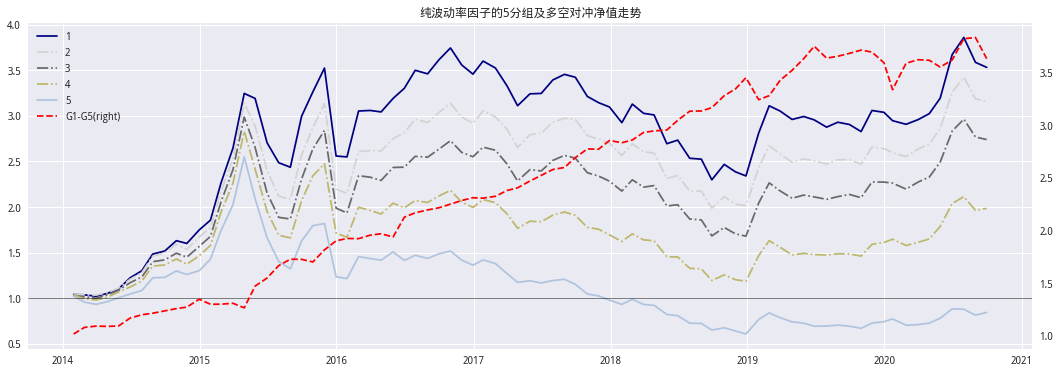

In [53]:
plot_nav(nav2,'纯波动率因子的5分组及多空对冲净值走势')

可以看到id_vol_deCorr的IC比单独与换手率因子正交要好，但任然弱于原始的ID_Vol因子，可平均时序相关系数、平均截面相关系数均下降很多。所以**在每月选股时，由于跨期截面相关性而被重复利用的过往因子信息，确实带来了干扰，削弱了当期因子的选股效果。**

In [54]:
id_vol_deCorr_ic= al.performance.factor_information_coefficient(id_vol_deCorr_factor)
id_vol_ic['id_vol_deCorr'] = id_vol_deCorr_ic
al.plotting.plot_information_table(id_vol_ic)

Information Analysis


,ID_Vol,ID_Vol_deTurn20,turn20,id_vol_deCorr
IC Mean,-0.112,-0.031,-0.079,-0.095
IC Std.,0.129,0.072,0.201,0.103
Risk-Adjusted IC,-0.864,-0.431,-0.394,-0.922
t-stat(IC),-7.775,-3.881,-3.549,-8.296
p-value(IC),0.000,0.000,0.001,0.000
IC Skew,0.060,0.201,0.459,-0.137
IC Kurtosis,1.017,0.376,-0.127,1.469


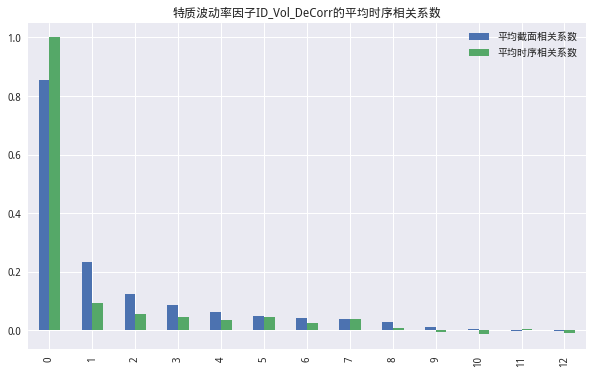

In [55]:
acf_df = id_vol_deCorr.apply(lambda x:acf(x,nlags=12))
corr_df = pd.concat((id_vol_deCorr.corrwith(id_vol.shift(-i)) for i in range(0,13)),axis=1)

df = pd.concat((corr_df.T.mean(axis=1),acf_df.mean(axis=1)),axis=1)
df.columns = ['平均截面相关系数','平均时序相关系数']
df.plot.bar(title='特质波动率因子ID_Vol_DeCorr的平均时序相关系数',figsize=(10,6))

## 纯波动率因子与换手率因子的相关性

相比于传统特质波动率因子，纯真波动率因子与换手率因子的相关性更低。同样将纯真波动率因子对换手率因子做正交化处理，检验残差的选股能力，并与传统因子进行对比。下图展示了新旧因子分别正交换手后，5分组多空对冲的净值走势，可以发现剔除换手率因子后，新因子的表现也明显优于传统因子。

In [57]:
idvol_deCturn20,turn20 = get_idvol_deturn20(id_vol_deCorr)

In [58]:
# 转换格式
idvol_deCturn20_ = idvol_deCturn20.stack().dropna()

# 因子分组排序默认未从小到大
idvol_deturn20_factor = al.utils.get_clean_factor_and_forward_returns(idvol_deCturn20_,
                                                            pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)

# 计算分组收益
rets3 = pd.pivot_table(idvol_deturn20_factor.reset_index(level=0),
                      index='date', columns='factor_quantile', values=1)

rets3['G1-G5'] = rets3[1] - rets3[5] 
nav3 = (1 + rets3).cumprod() # 计算净值

Dropped 22.6% entries from factor data (22.6% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


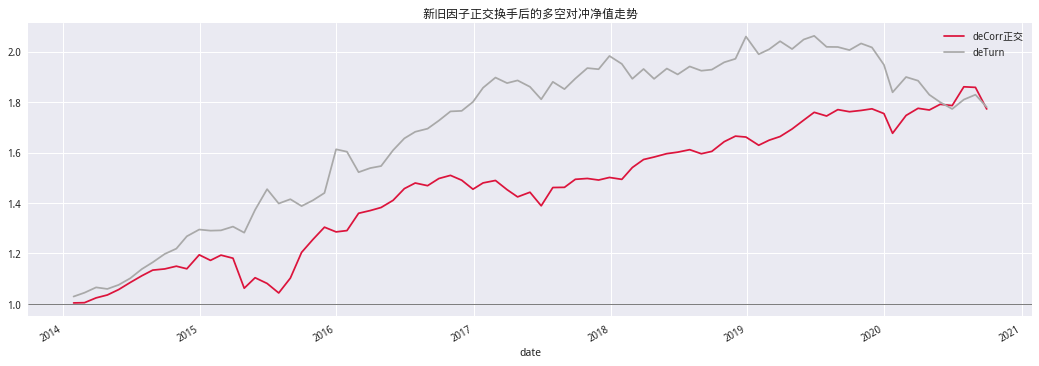

In [65]:
compare_df = pd.concat([nav3['G1-G5'],nav1['G1-G5']],axis=1)
compare_df.columns = ['deCorr正交','deTurn正交']

compare_df.plot(figsize=(18,6),title='新旧因子正交换手后的多空对冲净值走势',color=['Crimson','DarkGray'])
plt.axhline(1,color='black',lw=0.5)

# 使用CH3计算特质波动率

CH3因子的学术版构造过程见[Size and value in China](https://www.joinquant.com/research?target=research&url=/user/37149876885/notebooks/%E5%A4%8D%E7%8E%B0/Size%20and%20value%20in%20China.ipynb)这里我们依旧使用极简版构造，构造过程仿造FF3的极简版。

In [77]:
class CH3_ID_Vol(Factor):

    name = 'CH3_ID_Vol'
    max_window = 21
    dependencies = ['market_cap', 'pe_ratio', 'close']

    def calc(self, data):
        
        # 过滤市值底部30%是的股票
        market_cap = data['market_cap']
        market_cap_ser = market_cap.iloc[-1]
        # 30%
        threshold = market_cap_ser.quantile(0.3)
        stocks = market_cap_ser[market_cap_ser > threshold].index.tolist()
        
        # 获取符合条件的股票数据
        pe_df = data['pe_ratio'][stocks]
        market_cap = market_cap[stocks]
        close_df = data['close'][stocks]
        
        # 获取ep
        ep_df = 1. / pe_df
        # 收益率
        returns = close_df.pct_change()

        # 分组标记
        market_cap_label = self.add_label(market_cap, 10)
        ep_label = self.add_label(ep_df, 10)
        # 构造因子
        smb = self.calc_longshort(market_cap, market_cap_label, returns, 1, 10)
        vmg = self.calc_longshort(market_cap, ep_label, returns, 10, 1)
        mkt = (market_cap.div(market_cap.sum(
            axis=1), axis=0) * returns).sum(axis=1)

        # 添加阶矩项项
        exog = sm.add_constant(pd.concat([mkt, smb, vmg], axis=1))
        EXOG_COL = ['constant', 'mkt', 'smb', 'vmg']
        exog.columns = EXOG_COL

        returns = returns.iloc[-20:]
        exog = exog.reindex(returns.index)  # 日期索引对齐
        # OLS回归获取残差
        mod = sm.OLS(returns, exog)
        res = mod.fit()
        resid_df = res.resid

        return resid_df.iloc[-20:].std()

    def calc_longshort(self, market_cap:pd.DataFrame, label_df: pd.DataFrame, returns: pd.DataFrame, high: int, low: int) -> pd.Series:
        '''计算多空收益 high - low'''

        # 计算组合权重
        l_w = self.get_weight(label_df, market_cap, high)
        s_w = self.get_weight(label_df, market_cap, low)

        h = (l_w * returns).sum(axis=1)
        l = (s_w * returns).sum(axis=1)

        return h - l

    @staticmethod
    def add_label(df: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取分组 分位数分组(每组数量相同)'''
        return df.apply(lambda x: pd.qcut(x, N, labels=[i for i in range(1, N+1)]), axis=1)

    @staticmethod
    def get_weight(label_df: pd.DataFrame, market_cap: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取目标组的权重'''

        cond = (label_df == N)
        cap = cond * market_cap  # 该组市值

        return cap.div(cap.sum(axis=1), axis=0)

In [109]:
ch3_id_vol = get_factor('2013-01-01','2020-09-30',CH3_ID_Vol())

# 获取价格数据
ch3_pricing = get_factor_price(ch3_id_vol,'2020-10-31')

In [110]:
# 数据储存
ch3_id_vol.to_csv('../Data/ch3_id_vol.csv')
ch3_pricing.to_csv('../Data/ch3_pricing.csv')

In [111]:
# 数据读取
ch3_id_vol = pd.read_csv('../Data/ch3_id_vol.csv',index_col=[0],parse_dates=[0])
ch3_pricing = pd.read_csv('../Data/ch3_pricing.csv',index_col=[0],parse_dates=[0])

# 以2014年为起点
ch3_id_vol_1 = ch3_id_vol.loc['2014-01-01':]
ch3_pricing_1 = ch3_pricing.loc['2014-01-01':]

In [112]:
ch3_id_vol_ = ch3_id_vol_1.stack().dropna()
# 因子分组排序默认未从小到大
ch3_id_vol_factor = al.utils.get_clean_factor_and_forward_returns(ch3_id_vol_,
                                                            ch3_pricing_1,
                                                            periods=(1,),
                                                            quantiles=5)
# 计算分组收益
rets4 = pd.pivot_table(ch3_id_vol_factor.reset_index(level=0),
                      index='date', columns='factor_quantile', values=1)

rets4['G1-G5'] = rets4[1] - rets4[5] 
nav4 = (1 + rets4).cumprod() # 计算净值

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


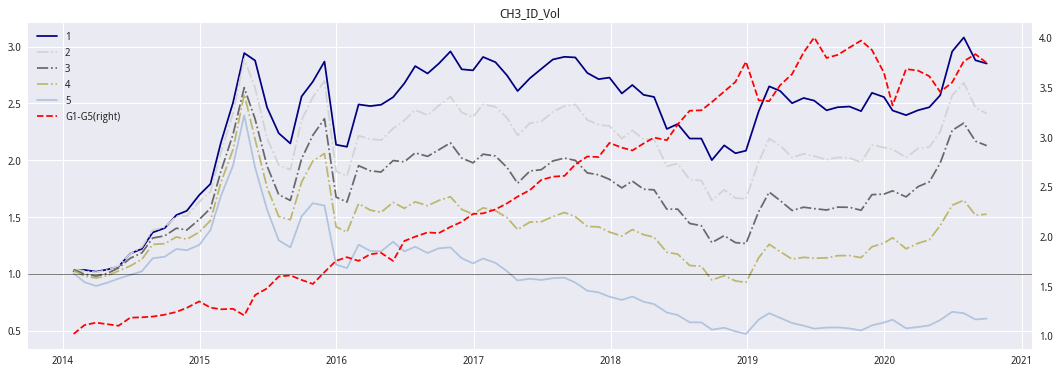

In [113]:
plot_nav(nav4,'CH3_ID_Vol')

In [115]:
ch3_id_vol_ic = al.performance.factor_information_coefficient(ch3_id_vol_factor)
ch3_id_vol_ic.columns=['CH3_ID_Vol']
al.plotting.plot_information_table(ch3_id_vol_ic)

Information Analysis


,CH3_ID_Vol
IC Mean,-0.109
IC Std.,0.141
Risk-Adjusted IC,-0.777
t-stat(IC),-6.995
p-value(IC),0.000
IC Skew,0.207
IC Kurtosis,0.545
